# Cell Nuclei Separation with Watershed

This notebook explores the Kaggle Data Science Bowl 2018 nuclei dataset and performs watershed-based segmentation.

In [1]:
# Core libraries
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Dataset root (update if you moved the dataset)
DATASET_ROOT = r"c:\Users\hp\OneDrive\Desktop\dlmi assignment\Cell Nuclei Separation — Watershed\data-science-bowl-2018"
TRAIN_DIR = os.path.join(DATASET_ROOT, "stage1_train")

print("Dataset root exists:", os.path.exists(DATASET_ROOT))
print("Train dir exists:", os.path.exists(TRAIN_DIR))

Dataset root exists: True
Train dir exists: True


## Dataset Structure
We inspect the folder structure and preview how images are organized.

In [2]:
def print_tree(root, max_depth=2):
    root = os.path.abspath(root)
    for dirpath, dirnames, filenames in os.walk(root):
        depth = dirpath[len(root):].count(os.sep)
        if depth > max_depth:
            dirnames[:] = []
            continue
        indent = "  " * depth
        print(f"{indent}{os.path.basename(dirpath)}/")
        for name in sorted(filenames)[:5]:
            print(f"{indent}  {name}")

print_tree(DATASET_ROOT, max_depth=2)

data-science-bowl-2018/
  stage1_sample_submission.csv/
    stage1_sample_submission.csv
  stage1_solution.csv/
    stage1_solution.csv
  stage1_test/
    0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/
    0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/
    0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/
    0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925/
    0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6/
    0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/
    1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c/
    17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff/
    1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b/
    191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829/
    1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a/
    1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e/
    1d9ea

## Watershed Utilities
Two segmentation strategies are implemented:
- **Weak markers**: markers from the raw Otsu mask (no distance transform).
- **Marker-controlled**: markers derived from distance transform (stronger foreground).

In [7]:
def load_image(path):
    # OpenCV on Windows can fail with non-ASCII paths; use imdecode for robustness
    data = np.fromfile(path, dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return img

def preprocess(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Otsu thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return gray, blurred, thresh

def watershed_weak_markers(img_bgr, thresh):
    # Markers from connected components on raw Otsu mask
    num_labels, markers = cv2.connectedComponents(thresh)
    markers = markers.astype(np.int32)

    # Watershed uses the image gradient implicitly via BGR image
    ws = cv2.watershed(img_bgr.copy(), markers)
    return ws

def watershed_marker_controlled(img_bgr, thresh):
    # Noise removal with opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Distance transform for sure foreground
    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.4 * dist.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)

    # Unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    ws = cv2.watershed(img_bgr.copy(), markers.astype(np.int32))
    return ws

def count_segments(ws_labels, background_label):
    labels = np.unique(ws_labels)
    labels = labels[labels != -1]
    labels = labels[labels != background_label]
    return int(len(labels))

def overlay_boundaries(img_bgr, ws_labels):
    overlay = img_bgr.copy()
    overlay[ws_labels == -1] = [255, 0, 0]  # red boundaries in BGR
    return overlay

## Assignment Focus
- Separate touching nuclei using watershed segmentation.
- Compare results **with vs without markers**.
- Observe how marker control reduces over-segmentation.

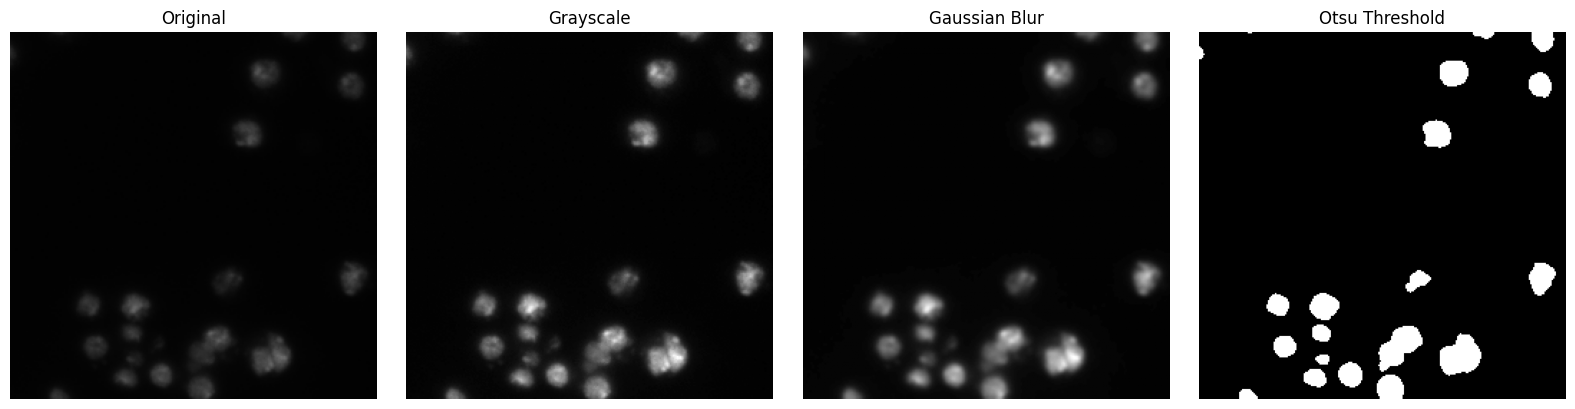

In [8]:
# Visualize the required preprocessing steps on a single image
preview_paths = sorted(glob.glob(os.path.join(TRAIN_DIR, "*", "images", "*.png")))
if not preview_paths:
    raise FileNotFoundError("No images found in stage1_train.")

preview_img = load_image(preview_paths[0])
gray, blurred, thresh = preprocess(preview_img)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(cv2.cvtColor(preview_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(gray, cmap="gray")
axes[1].set_title("Grayscale")
axes[1].axis("off")

axes[2].imshow(blurred, cmap="gray")
axes[2].set_title("Gaussian Blur")
axes[2].axis("off")

axes[3].imshow(thresh, cmap="gray")
axes[3].set_title("Otsu Threshold")
axes[3].axis("off")

plt.tight_layout()
plt.show()

## Run on Multiple Images and Compare
We display the results side by side and compute the average nuclei counts.

Total images found: 670


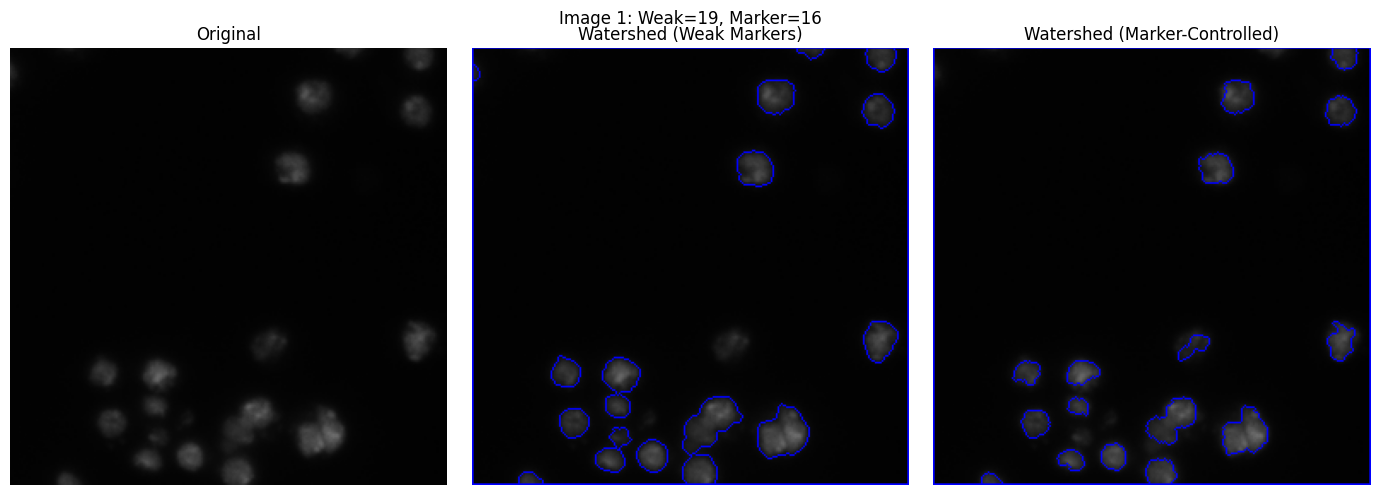

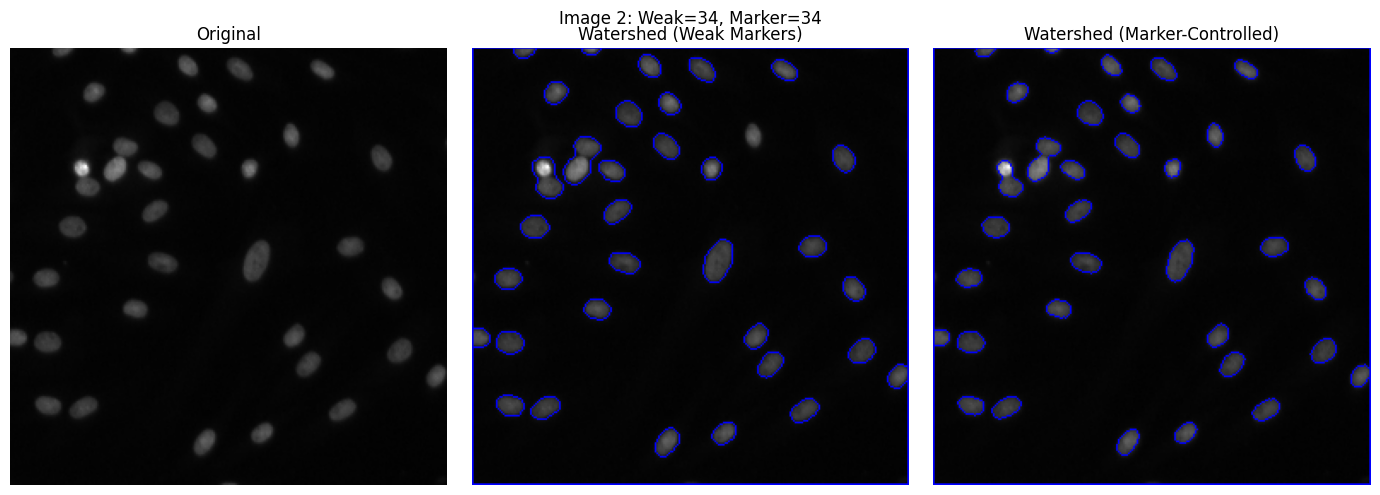

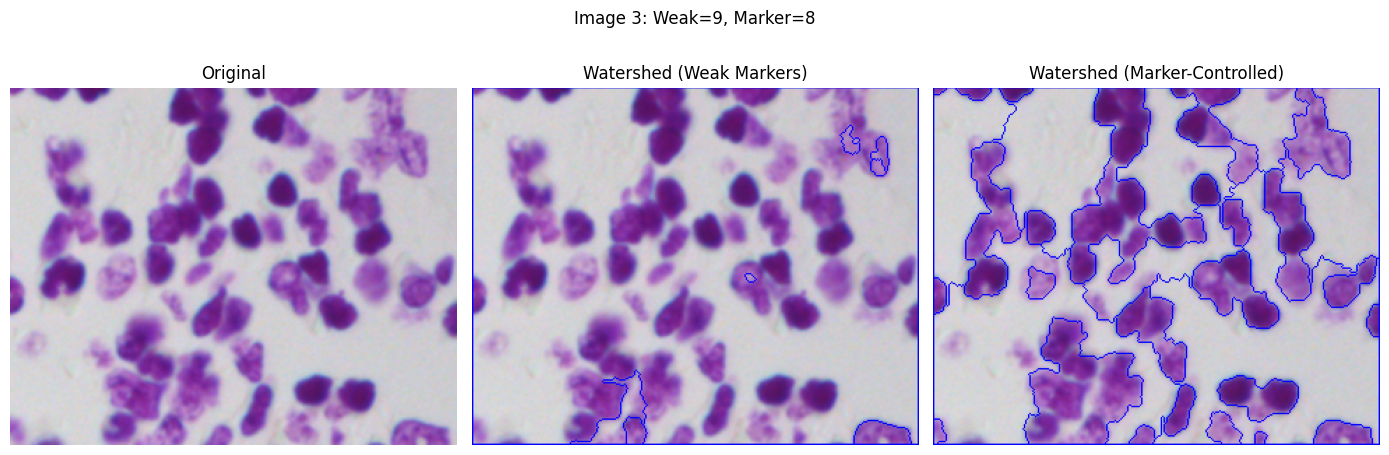

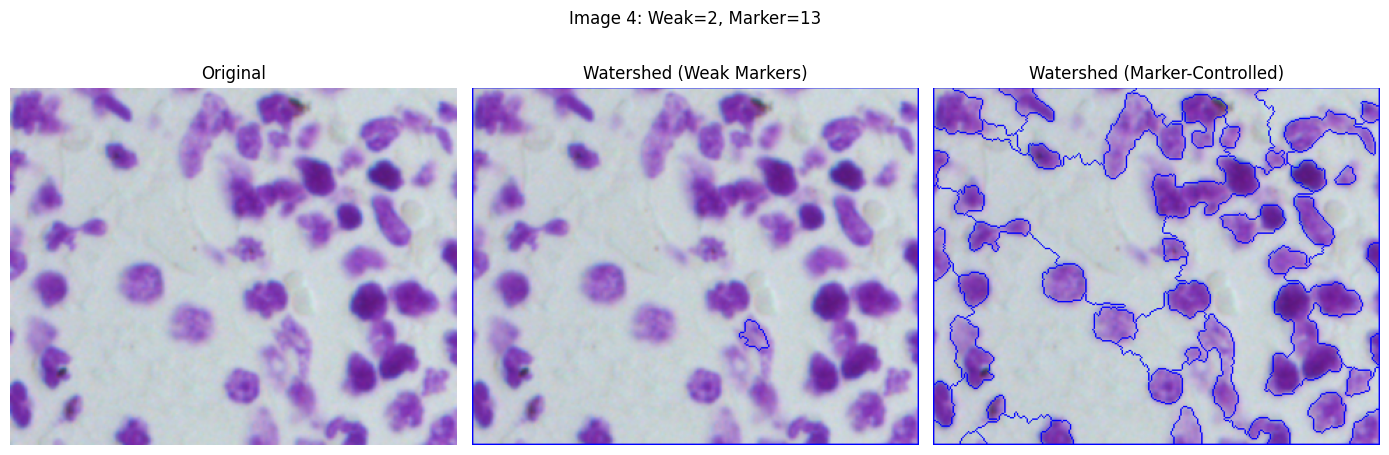

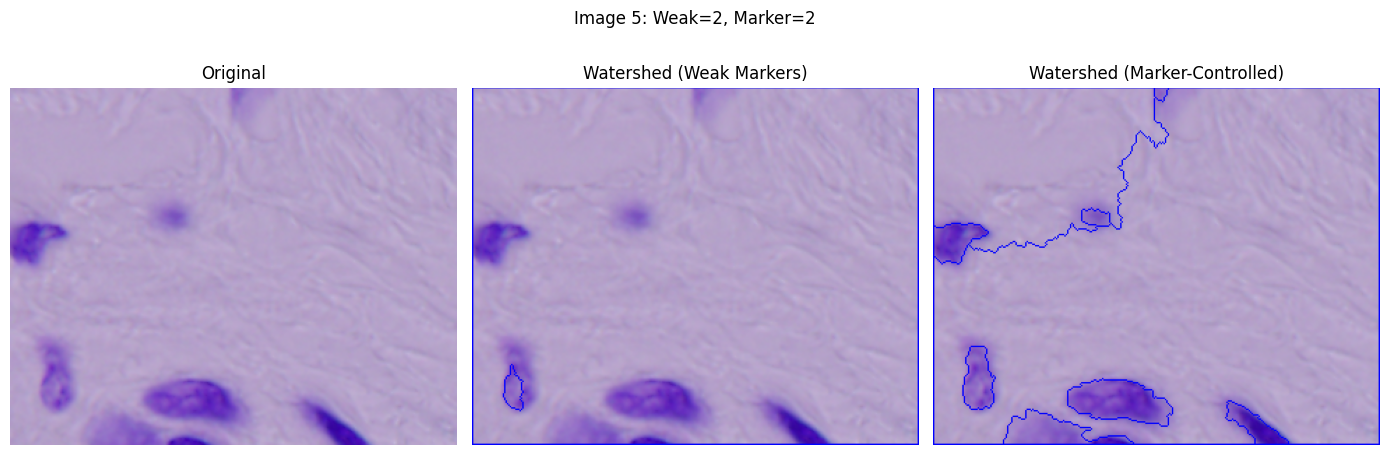

Average weak-marker count over 5 images: 13.20
Average marker-controlled count over 5 images: 14.60


In [9]:
# Collect image paths from stage1_train
image_paths = sorted(glob.glob(os.path.join(TRAIN_DIR, "*", "images", "*.png")))
print("Total images found:", len(image_paths))

max_images = 5
sample_paths = image_paths[:max_images]

weak_counts = []
marker_counts = []

for idx, img_path in enumerate(sample_paths, 1):
    img = load_image(img_path)
    gray, blurred, thresh = preprocess(img)

    ws_weak = watershed_weak_markers(img, thresh)
    ws_marker = watershed_marker_controlled(img, thresh)

    count_weak = count_segments(ws_weak, background_label=0)
    count_marker = count_segments(ws_marker, background_label=1)

    weak_counts.append(count_weak)
    marker_counts.append(count_marker)

    # Display side-by-side results
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    fig.suptitle(f"Image {idx}: Weak={count_weak}, Marker={count_marker}")

    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(overlay_boundaries(img, ws_weak), cv2.COLOR_BGR2RGB))
    axes[1].set_title("Watershed (Weak Markers)")
    axes[1].axis("off")

    axes[2].imshow(cv2.cvtColor(overlay_boundaries(img, ws_marker), cv2.COLOR_BGR2RGB))
    axes[2].set_title("Watershed (Marker-Controlled)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

avg_weak = float(np.mean(weak_counts)) if weak_counts else 0.0
avg_marker = float(np.mean(marker_counts)) if marker_counts else 0.0

print(f"Average weak-marker count over {len(weak_counts)} images: {avg_weak:.2f}")
print(f"Average marker-controlled count over {len(marker_counts)} images: {avg_marker:.2f}")